In [1]:
import pandas as pd
import numpy as np
import logging
import sys
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [4]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Set up logging for Jupyter Notebook
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(message)s", force=True)

def optimize_feature_selection(X, y, task="classification", method="select_k_best"):
    """ Perform hyperparameter tuning for feature selection methods """
    if task == "classification":
        score_func = f_classif
        model = RandomForestClassifier(random_state=42)
    else:
        score_func = f_regression
        model = RandomForestRegressor(random_state=42)
    
    if method == "select_k_best":
        param_grid = {'k': [5, 10, 15, 20, min(25, X.shape[1])]}  # Different values of k
        best_k = param_grid['k'][0]
        best_score = -1
        for k in param_grid['k']:
            selector = SelectKBest(score_func=score_func, k=k)
            X_selected = selector.fit_transform(X, y)
            score = np.mean(cross_val_score(model, X_selected, y, cv=5, scoring='accuracy' if task == "classification" else 'neg_mean_squared_error'))
            if score > best_score:
                best_k, best_score = k, score
        return SelectKBest(score_func=score_func, k=best_k).fit_transform(X, y)
    
    elif method == "rfe":
        param_grid = {'n_features_to_select': [5, 10, 15, 20, min(25, X.shape[1])]}  # Different values of n_features
        best_features = param_grid['n_features_to_select'][0]
        best_score = -1
        for n in param_grid['n_features_to_select']:
            selector = RFE(model, n_features_to_select=n)
            X_selected = selector.fit_transform(X, y)
            score = np.mean(cross_val_score(model, X_selected, y, cv=5, scoring='accuracy' if task == "classification" else 'neg_mean_squared_error'))
            if score > best_score:
                best_features, best_score = n, score
        return RFE(model, n_features_to_select=best_features).fit_transform(X, y)
    
    elif method == "feature_importance":
        model.fit(X, y)
        importance_scores = model.feature_importances_
        thresholds = np.linspace(0.005, 0.05, 5)  # Test different threshold values
        best_threshold = thresholds[0]
        best_score = -1
        for threshold in thresholds:
            selected_features = X.columns[importance_scores > threshold]
            X_selected = X[selected_features]
            if X_selected.shape[1] == 0:
                continue
            score = np.mean(cross_val_score(model, X_selected, y, cv=5, scoring='accuracy' if task == "classification" else 'neg_mean_squared_error'))
            if score > best_score:
                best_threshold, best_score = threshold, score
        return X[X.columns[importance_scores > best_threshold]]
    
    else:
        raise ValueError("Invalid method. Choose from 'select_k_best', 'rfe', or 'feature_importance'.")

def plot_classification_results(results):
    methods = list(results.keys())  # Feature selection methods
    classifiers = ["Random Forest", "SVM", "Naive Bayes"]  # Model names
    
    # Create two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    
    num_methods = len(methods)
    for method_idx, method in enumerate(methods):
        labels = list(results[method].keys())  # Classification labels
        x = np.arange(len(labels))  # Positions for bars
        width = 0.25 / num_methods  # Adjusted for spacing
        
        for i, model in enumerate(classifiers):
            # Get accuracies and their STDs
            accuracies = []
            accuracy_stds = []
            f1_scores = []
            f1_stds = []
            
            for label in labels:
                if model in results[method][label]:
                    accuracies.append(results[method][label][model]["accuracy"])
                    accuracy_stds.append(results[method][label][model]["accuracy_std"])
                    f1_scores.append(results[method][label][model]["f1_score"])
                    f1_stds.append(results[method][label][model]["f1_std"])
                else:
                    accuracies.append(0)
                    accuracy_stds.append(0)
                    f1_scores.append(0)
                    f1_stds.append(0)
            
            # Plot accuracy bars with error bars
            position = x + (i + method_idx * len(classifiers)) * width
            ax1.bar(position, accuracies, width=width, 
                   label=f"{method} - {model}")
            ax1.errorbar(position, accuracies, yerr=accuracy_stds, 
                        fmt='none', color='black', capsize=3)
            
            # Plot F1 score bars with error bars
            ax2.bar(position, f1_scores, width=width, 
                   label=f"{method} - {model}")
            ax2.errorbar(position, f1_scores, yerr=f1_stds, 
                        fmt='none', color='black', capsize=3)
    
    # Customize first subplot (Accuracy)
    ax1.set_xticks(x + (num_methods * len(classifiers) * width) / 2)
    ax1.set_xticklabels(labels, rotation=45)
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    ax1.set_title('Classification Accuracy Across Feature Selection Methods')
    ax1.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Customize second subplot (F1 Score)
    ax2.set_xticks(x + (num_methods * len(classifiers) * width) / 2)
    ax2.set_xticklabels(labels, rotation=45)
    ax2.set_ylabel('F1 Score')
    ax2.set_ylim(0, 1)
    ax2.set_title('F1 Scores Across Feature Selection Methods')
    ax2.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Add legend to the right of both plots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5))
    
    plt.tight_layout()
    plt.show()


def plot_regression_results(results):
    methods = list(results.keys())  # Feature selection methods
    regressors = ["Random Forest", "SVM"]  # Model names
    num_methods = len(methods)

    plt.figure(figsize=(14, 7))

    for method_idx, method in enumerate(methods):
        labels = list(results[method].keys())  # Regression labels
        x = np.arange(len(labels))  # Positions for bars
        width = 0.25 / num_methods  # Adjusted for spacing

        for i, model in enumerate(regressors):
            percentage_errors = [
                results[method][label][model]["percentage_error"] if model in results[method][label] else 0
                for label in labels
            ]
            plt.bar(x + (i + method_idx * len(regressors)) * width, percentage_errors, width=width, label=f"{method} - {model}")

    plt.xticks(x + (num_methods * len(regressors) * width) / 2, labels, rotation=45)
    plt.ylabel('Mean Percentage Error (%)')
    plt.title('Regression Mean Percentage Error Across Feature Selection Methods')
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Move legend to the right
    plt.tight_layout()
    plt.show()


def load_data(file_path, sheet_name="Sheet1", skip_rows=2):
    logging.info("Loading dataset...")
    df = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=skip_rows)
    # df.dropna(axis=1, how='all', inplace=True)
    df.dropna(axis=0, how='all', inplace=True)
    return df

def map_excel_columns(df):
    column_mapping = {}
    for idx, col_name in enumerate(df.columns):
        col_letter = ""
        col_number = idx + 1
        while col_number > 0:
            col_number, remainder = divmod(col_number - 1, 26)
            col_letter = chr(65 + remainder) + col_letter
        column_mapping[col_letter] = col_name
    return column_mapping

def extract_features_labels(df, excel_mapping, feature_cols, class_labels, reg_labels):
    features = [excel_mapping[col] for col in feature_cols if col in excel_mapping]
    class_names = [excel_mapping[col] for col in class_labels if col in excel_mapping]
    reg_names = [excel_mapping[col] for col in reg_labels if col in excel_mapping]

    df = df[df["Disease"] == 1]
    
    X = df[features].copy()
    y_classification = df[class_names].copy()
    y_regression = df[reg_names].copy()

    X.reset_index(drop=True, inplace=True)
    y_classification.reset_index(drop=True, inplace=True)
    y_regression.reset_index(drop=True, inplace=True)
    
    return X, y_classification, y_regression

def preprocess_data(X):
    logging.info("Preprocessing features...")
    for col in X.select_dtypes(include=['datetime64']).columns:
        X[col] = X[col].apply(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
    for col in X.select_dtypes(include=['object']).columns:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))
    imputer = SimpleImputer(strategy="mean")
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)
    return X_scaled

def preprocess_labels(y_classification):
    for col in y_classification.columns:
        if y_classification[col].dtype in ['float64', 'int64']:
            y_classification[col] = pd.cut(y_classification[col], bins=[-np.inf, 0, np.inf], labels=[0, 1])
        y_classification[col] = LabelEncoder().fit_transform(y_classification[col].astype(str))
    y_classification.fillna(y_classification.mode().iloc[0], inplace=True)
    y_classification = y_classification.loc[:, y_classification.nunique() > 1]
    return y_classification

def preprocess_regression_labels(y_regression):
    for col in y_regression.columns:
        y_regression[col] = pd.to_numeric(y_regression[col], errors='coerce')
        y_regression[col].fillna(y_regression[col].median(), inplace=True)
    return y_regression

def train_classification_models(X, y_classification, feature_selection_method="select_k_best", cv=5, k=10):
    """ Train classification models with cross-validation and feature selection for each label separately """
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    classifiers = {
        "Random Forest": RandomForestClassifier(random_state=42),
    }
    
    classification_results = {}
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    for label in y_classification.columns:
        y_label = y_classification[label].dropna()  # Ensure no missing values
        X_label = X.loc[y_label.index]  # Get corresponding rows
        
        if len(y_label.unique()) > 1:  # Ensure multiple classes exist
            # Apply feature selection for this label
            X_selected = optimize_feature_selection(X_label, y_label, task="classification", method=feature_selection_method)
            classification_results[label] = {}

            for model_name, model in classifiers.items():
                grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
                grid_search.fit(X_selected, y_label)
                best_model = grid_search.best_estimator_
                
                accuracy_scores = cross_val_score(best_model, X_selected, y_label, cv=kf, scoring='accuracy')
                f1_scores = cross_val_score(best_model, X_selected, y_label, cv=kf, scoring='f1_macro')
                y_pred = cross_val_predict(best_model, X_selected, y_label, cv=kf)
                
                classification_results[label][model_name] = {
                    "best_model_params": grid_search.best_params_,
                    "accuracy": np.mean(accuracy_scores),  # Mean accuracy across folds
                    "accuracy_std": np.std(accuracy_scores),  # STD accuracies
                    "f1_score": np.mean(f1_scores),  # Mean F1 score across folds
                    "f1_std": np.std(f1_scores),  # STD of F1 scores
                    "report": classification_report(y_label, y_pred, output_dict=True)
                }

    return classification_results


def train_regression_models(X, y_regression, feature_selection_method="select_k_best", cv=5, k=10):
    """ Train regression models with cross-validation and feature selection for each label separately """
    regressors = {
        "Random Forest": RandomForestRegressor(random_state=42),
        "SVM": SVR()
    }

    regression_results = {}
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    for label in y_regression.columns:
        y_label = y_regression[label].dropna()  # Ensure no missing values
        X_label = X.loc[y_label.index]  # Get corresponding rows

        # Apply feature selection for this label
        X_selected = select_features(X_label, y_label, task="regression", method=feature_selection_method, k=k)

        regression_results[label] = {}

        for model_name, model in regressors.items():
            # Cross-validated predictions
            y_pred = cross_val_predict(model, X_selected, y_label, cv=kf)

            # Compute percentage error
            percentage_errors = np.abs((y_pred - y_label) / y_label) * 100
            mean_percentage_error = np.mean(percentage_errors)

            # Compute standard regression metrics
            mae = mean_absolute_error(y_label, y_pred)
            mse = mean_squared_error(y_label, y_pred)
            rmse = np.sqrt(mse)

            regression_results[label][model_name] = {
                "mae": mae,
                "mse": mse,
                "rmse": rmse,
                "percentage_error": mean_percentage_error
            }

    return regression_results


In [5]:
# Define feature and label columns
feature_cols = ["E", "G", "K", "M", "O", "Q", "T", "U", "BK", "BM", "BT", "BV", "BW", "CB", "CC", "CJ", "CK", "CL", "CM", "CN", "CO", "CP", "CT", "DB", "DD", "DF", "DH", "DK", "DL", "DN", "DO", "DU", "DV", "EI", "ES", "FB", "FC", "HQ", "HR", "HS", "HT"]
classification_labels = ["FD", "FP", "GD", "GO", "GW"]
regression_labels = ["GR", "GY"]

file_path = "/kaggle/input/aml-mds-data/Copy of ML for AML MDS - for FG.xlsx"
df = load_data(file_path)
excel_column_mapping = map_excel_columns(df)

X, y_classification, y_regression = extract_features_labels(df, excel_column_mapping, feature_cols, classification_labels, regression_labels)
X_preprocessed = preprocess_data(X)
y_classification = preprocess_labels(y_classification)
y_regression = preprocess_regression_labels(y_regression)

Loading dataset...
Preprocessing features...


             aGVHD     cGVHD  Relapse?     Dead?       RFS
aGVHD     1.000000  0.089791 -0.065770  0.031652  0.019123
cGVHD     0.089791  1.000000 -0.228997 -0.431490 -0.411849
Relapse? -0.065770 -0.228997  1.000000  0.282874  0.579226
Dead?     0.031652 -0.431490  0.282874  1.000000  0.828568
RFS       0.019123 -0.411849  0.579226  0.828568  1.000000


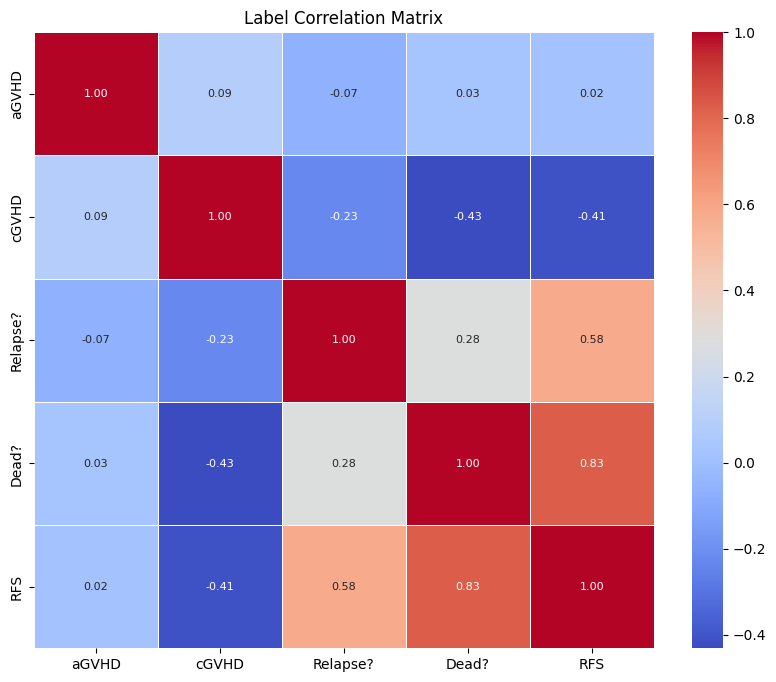

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataframe is named df
correlation_matrix = y_classification.corr()

# Display correlation matrix
print(correlation_matrix)

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8}, linewidths=0.5)
plt.title("Label Correlation Matrix")
plt.show()


🔹 Running Feature Selection with select_k_best 🔹


✅ Completed Feature Selection with select_k_best ✅


🔹 Running Feature Selection with rfe 🔹


✅ Completed Feature Selection with rfe ✅


🔹 Running Feature Selection with feature_importance 🔹


✅ Completed Feature Selection with feature_importance ✅



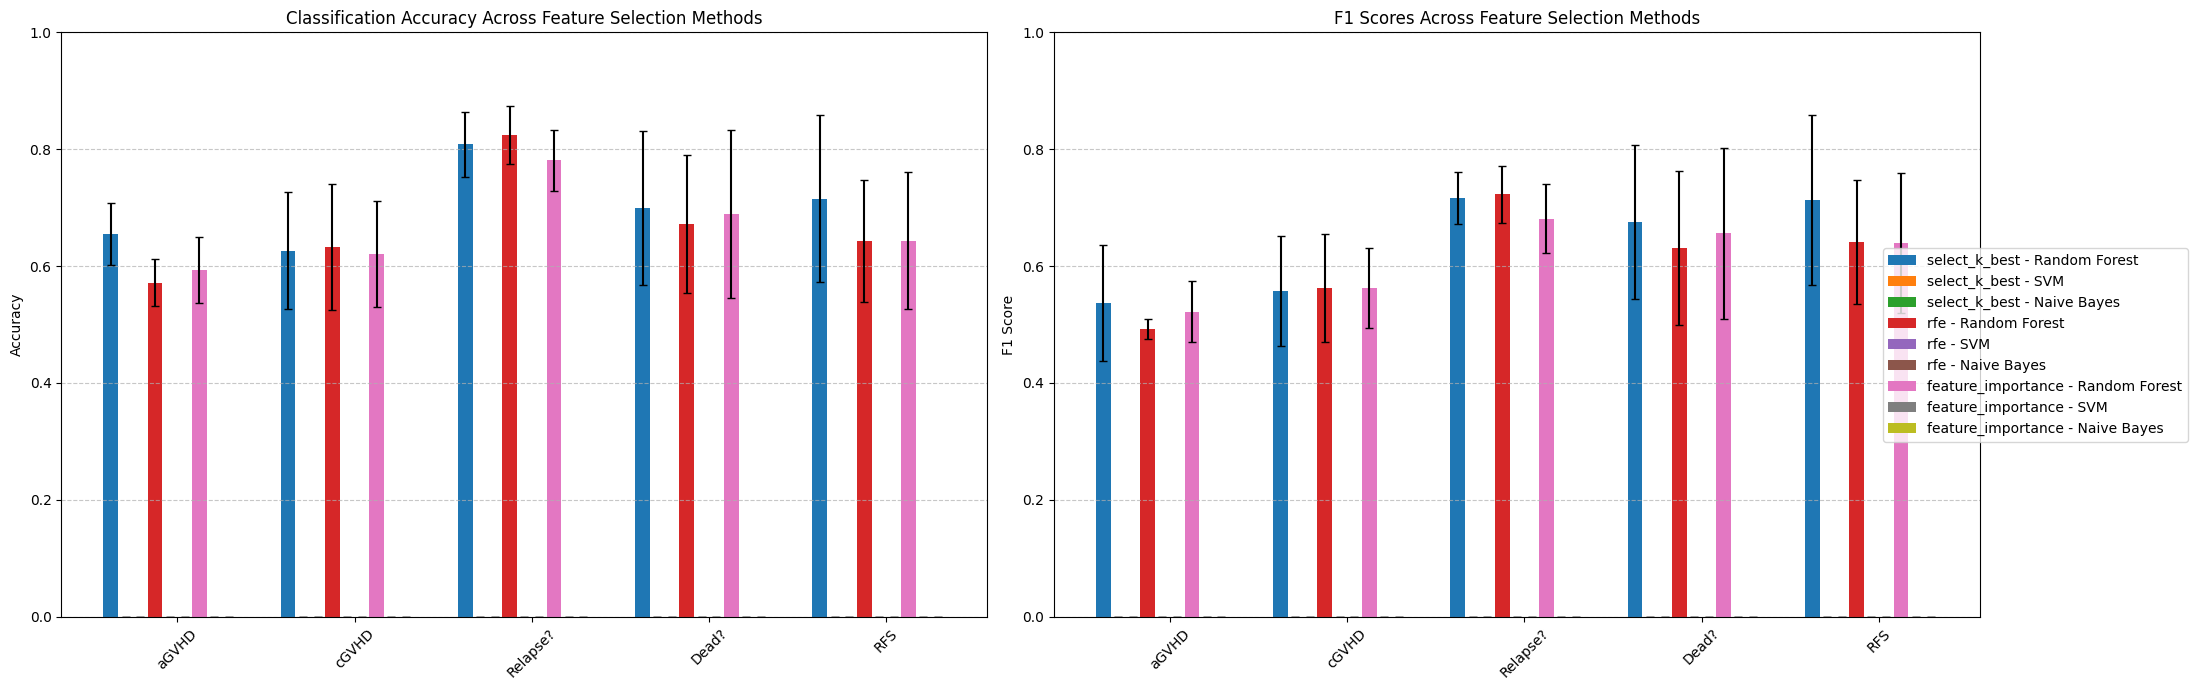

In [6]:
# feature_selection_methods = ["select_k_best", "rfe", "feature_importance", "pca"]
feature_selection_methods = ["select_k_best", "rfe", "feature_importance"]
classification_results_all = {}
regression_results_all = {}

for method in feature_selection_methods:
    print(f"\n🔹 Running Feature Selection with {method} 🔹\n")
    
    # Train Classification Models
    classification_results = train_classification_models(X, y_classification, feature_selection_method=method, k=15)

    # Train Regression Models
    # regression_results = train_regression_models(X, y_regression, feature_selection_method=method, k=10)

    # Store Results
    classification_results_all[method] = classification_results
    # regression_results_all[method] = regression_results

    print(f"\n✅ Completed Feature Selection with {method} ✅\n")


plot_classification_results(classification_results_all)
# plot_regression_results(regression_results_all)

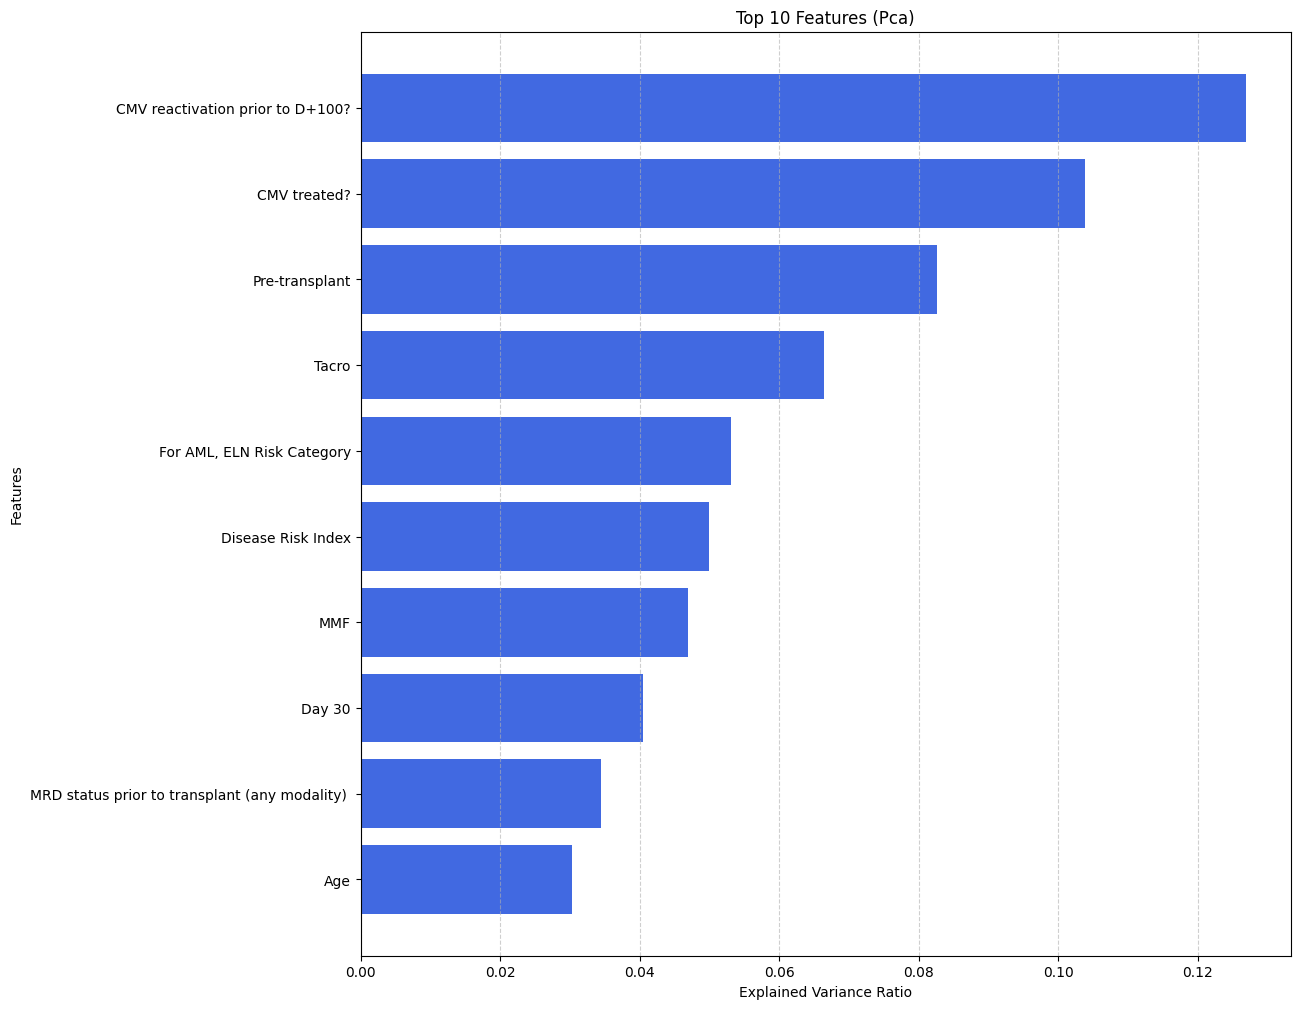

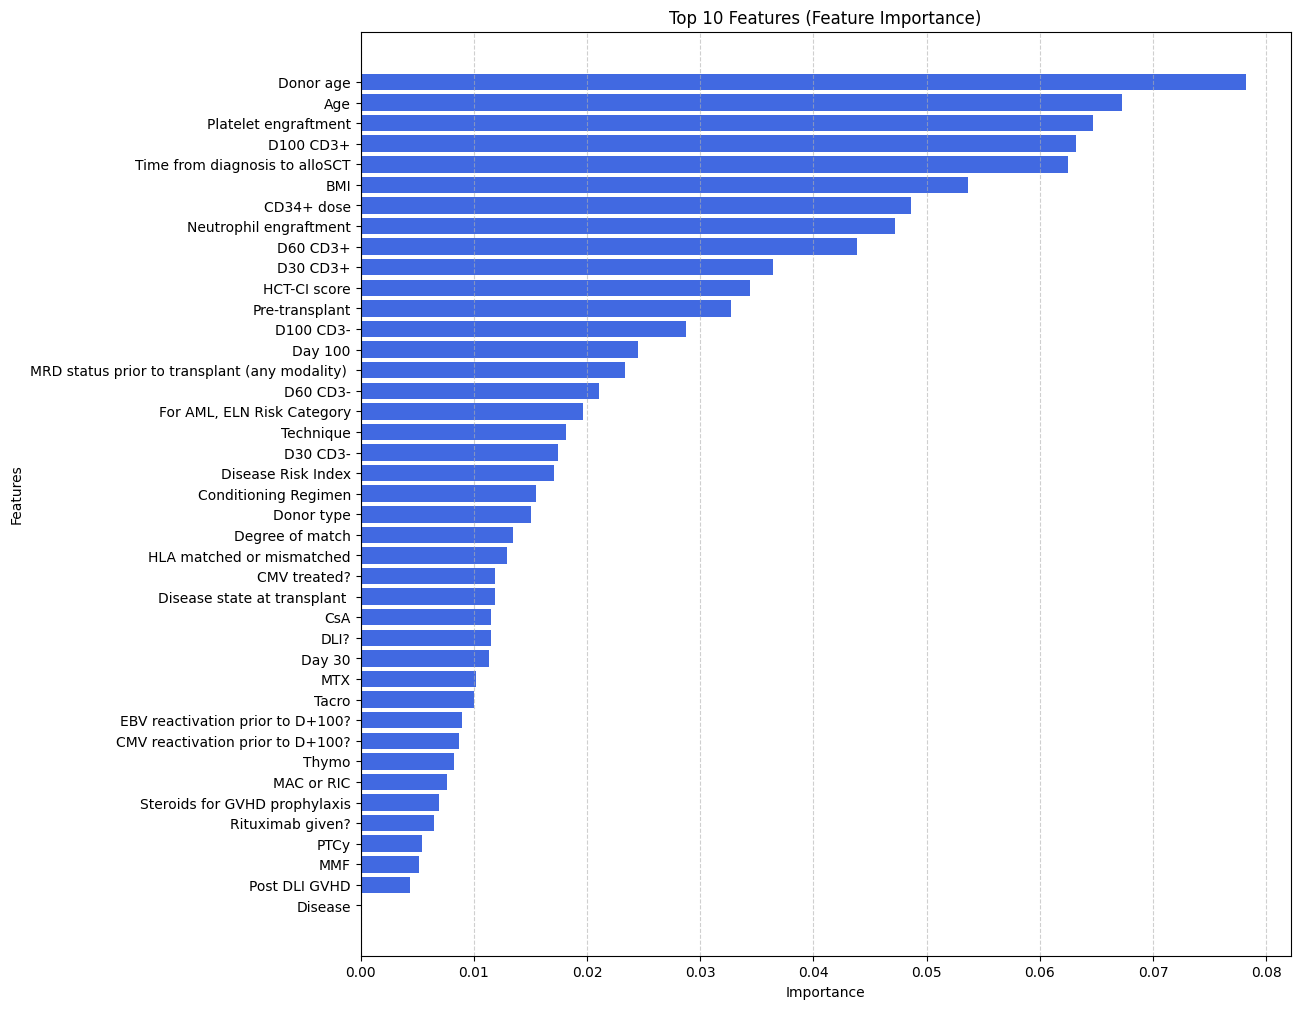

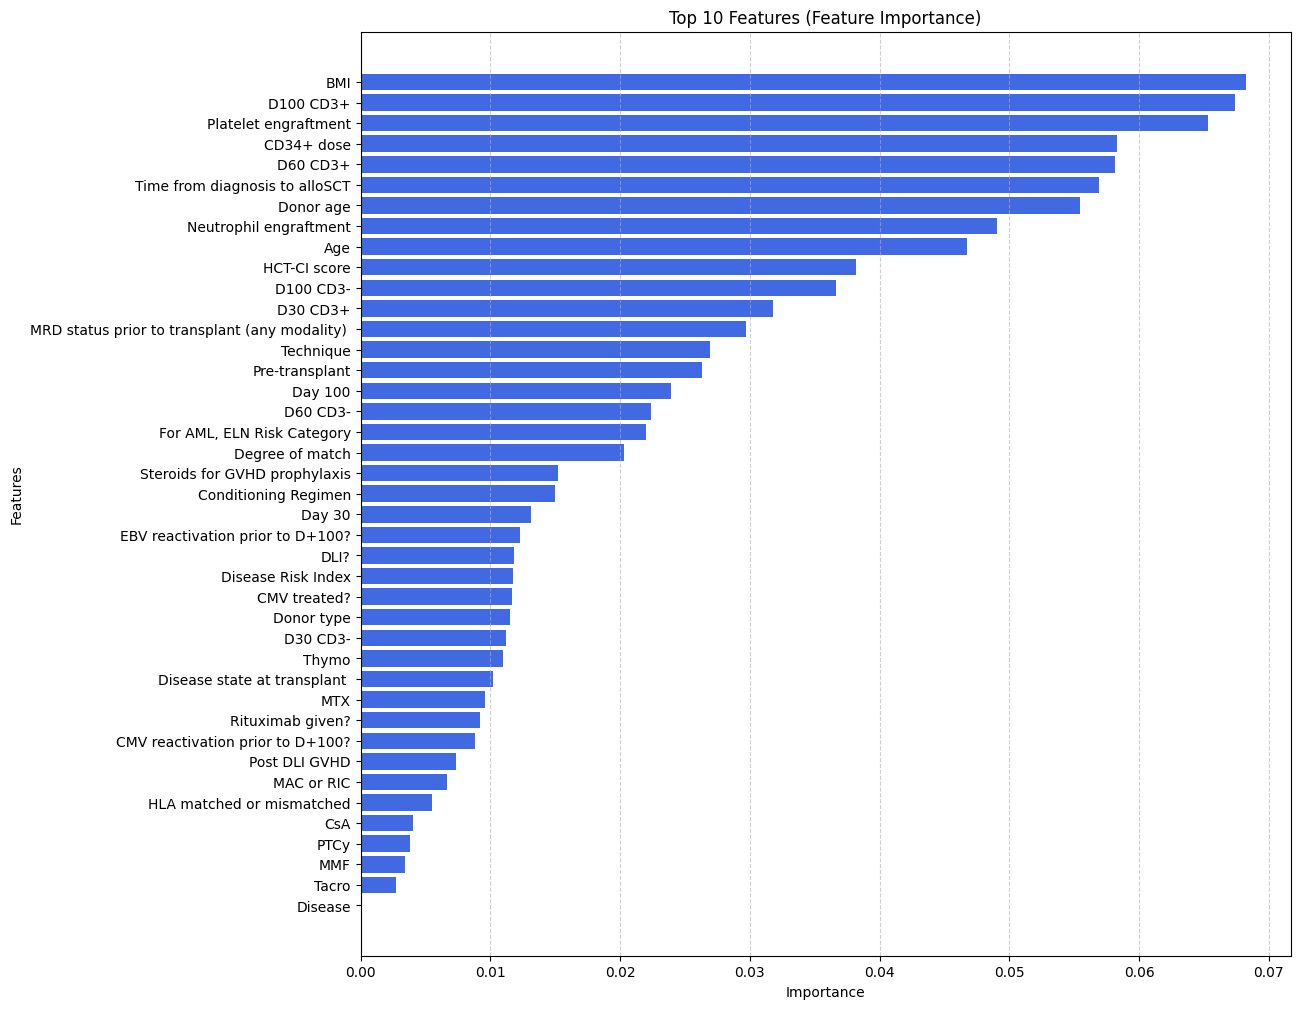

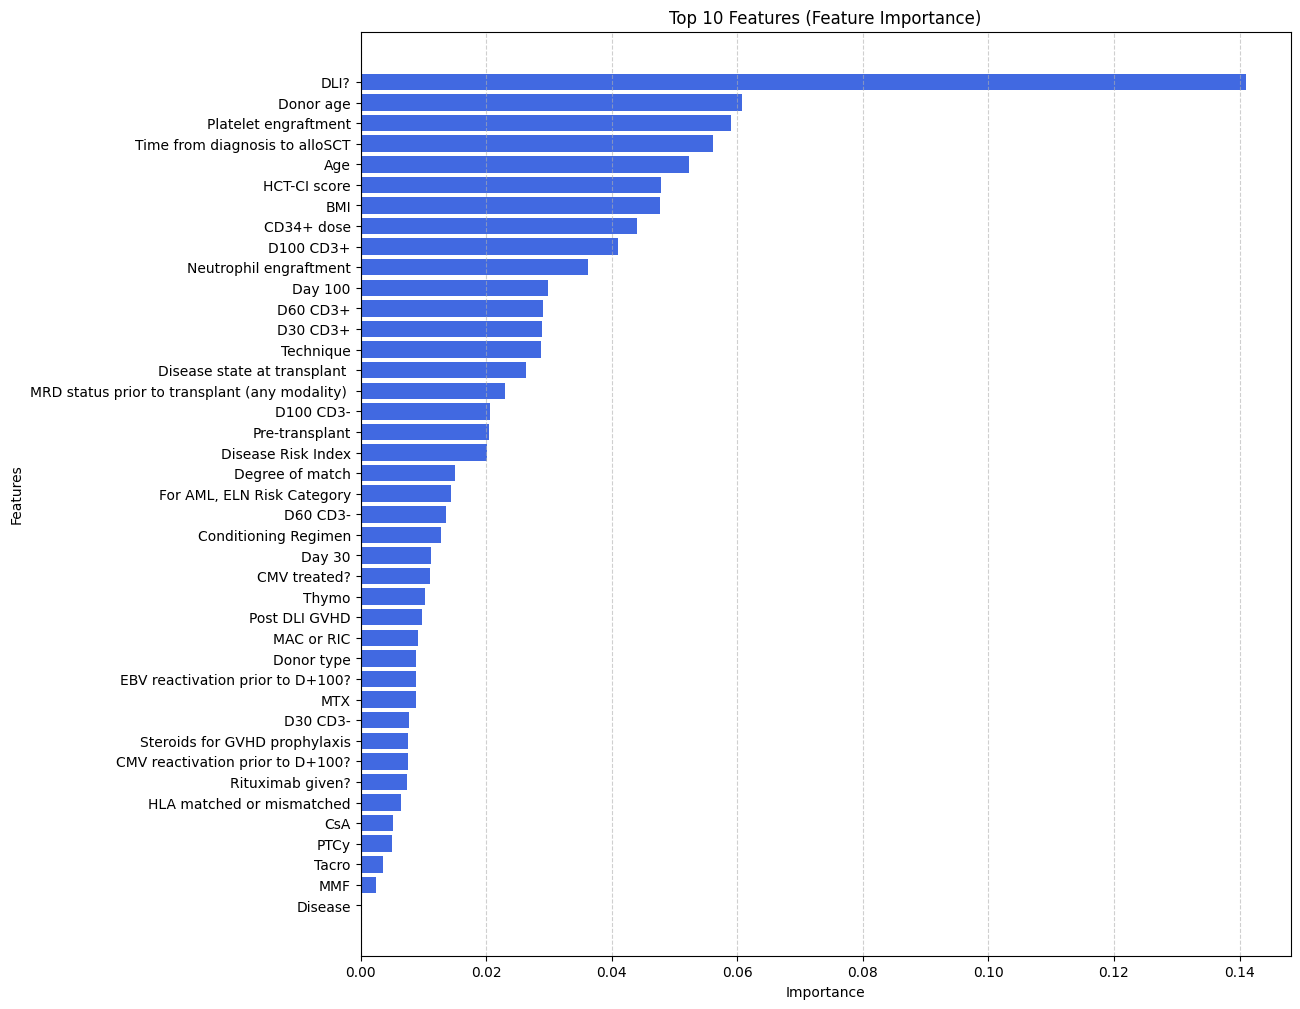

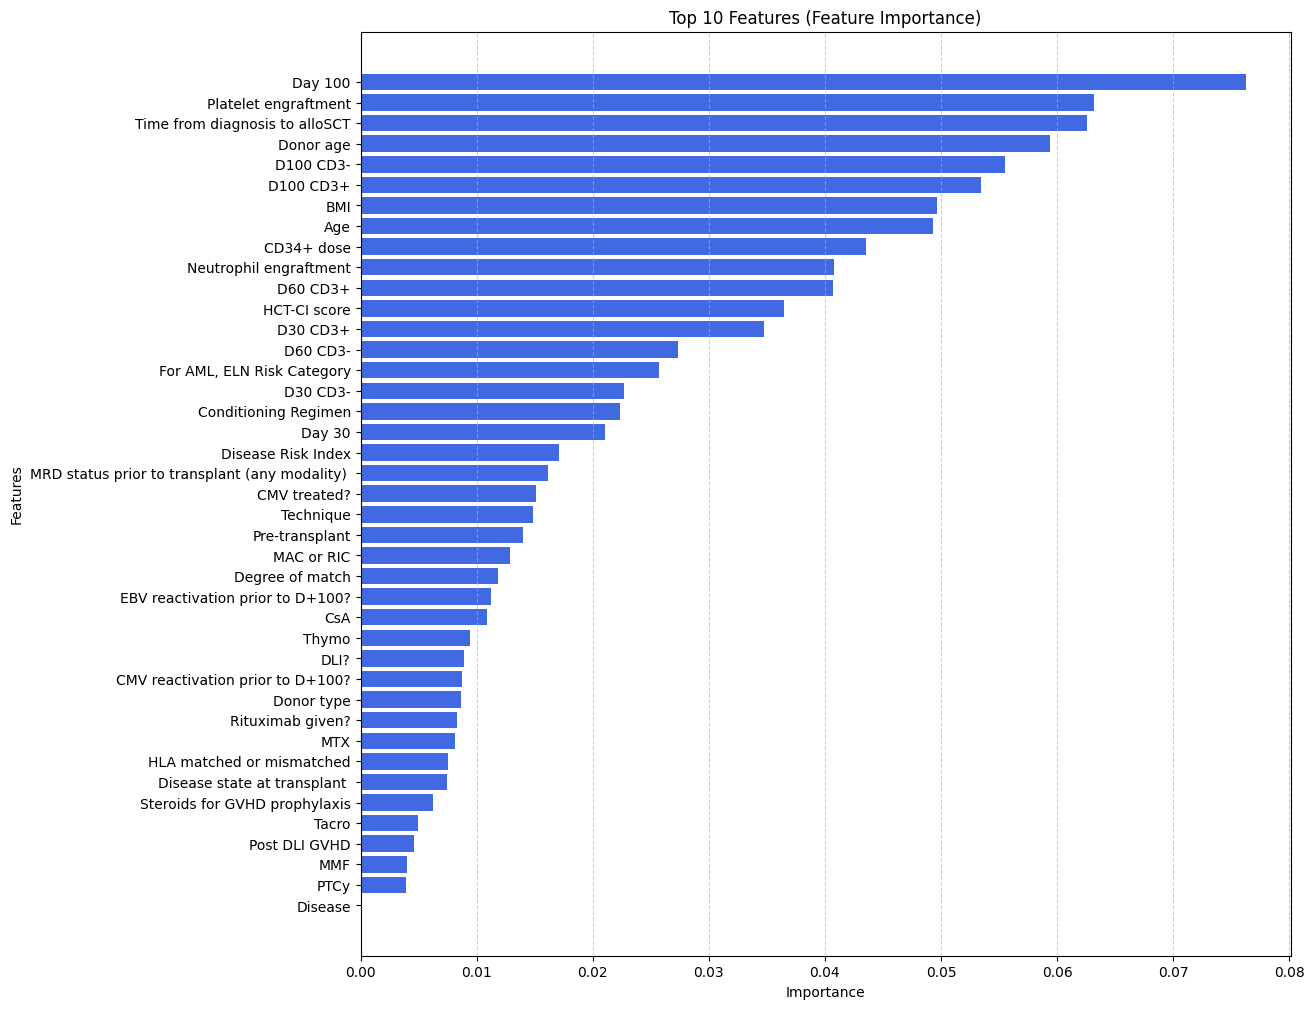

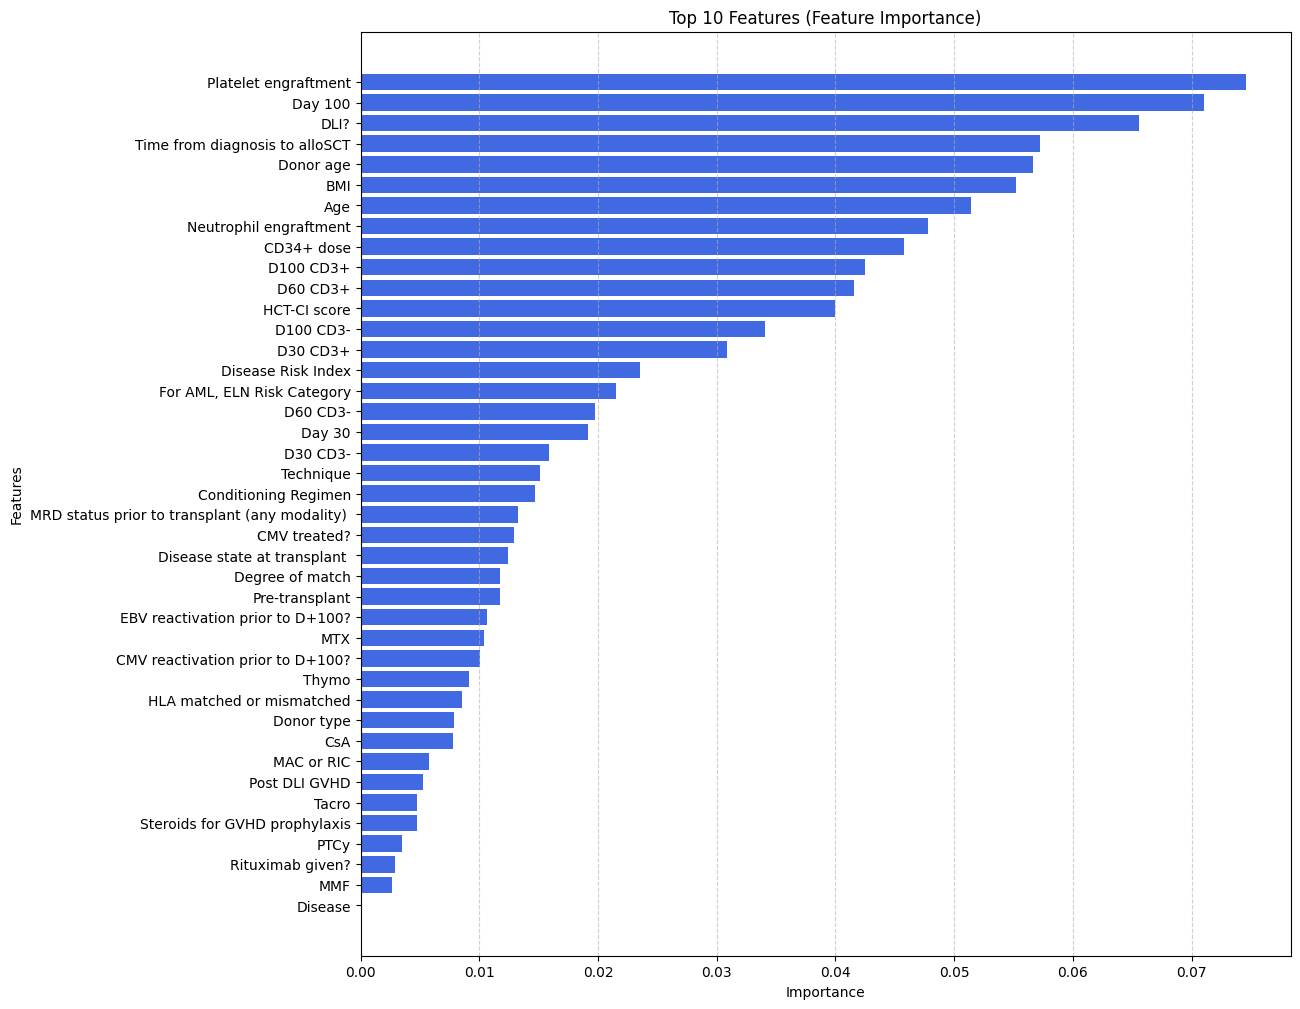

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_feature_importance(X, y, task="classification", method="feature_importance", n_components=10):
    """ Plot feature importance using different methods """
    if task == "classification":
        model = RandomForestClassifier(random_state=42)
    else:
        model = RandomForestRegressor(random_state=42)

    if method == "feature_importance":
        model.fit(X, y)
        importance_scores = model.feature_importances_
        sorted_indices = np.argsort(importance_scores)[::-1]
        sorted_features = X.columns[sorted_indices]
        sorted_scores = importance_scores[sorted_indices]
    
    elif method == "pca":
        pca = PCA(n_components=min(n_components, X.shape[1]))
        X_pca = pca.fit_transform(X)
        sorted_indices = np.argsort(pca.components_.sum(axis=0))[::-1]
        sorted_features = X.columns[sorted_indices][:n_components]
        sorted_scores = pca.explained_variance_ratio_[:n_components]
    
    else:
        raise ValueError("Invalid method. Choose from 'feature_importance' or 'pca'.")
    
    # Plot
    plt.figure(figsize=(12, 12))
    plt.barh(sorted_features[::-1], sorted_scores[::-1], color='royalblue')
    plt.xlabel("Importance" if method == "feature_importance" else "Explained Variance Ratio")
    plt.ylabel("Features")
    plt.title(f"Top {n_components} Features ({method.replace('_', ' ').title()})")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

plot_feature_importance(X_preprocessed, y_classification.iloc[:, 0], task="classification", method="pca")

for idx in range(5):
    plot_feature_importance(X_preprocessed, y_classification.iloc[:, idx], task="classification", method="feature_importance")

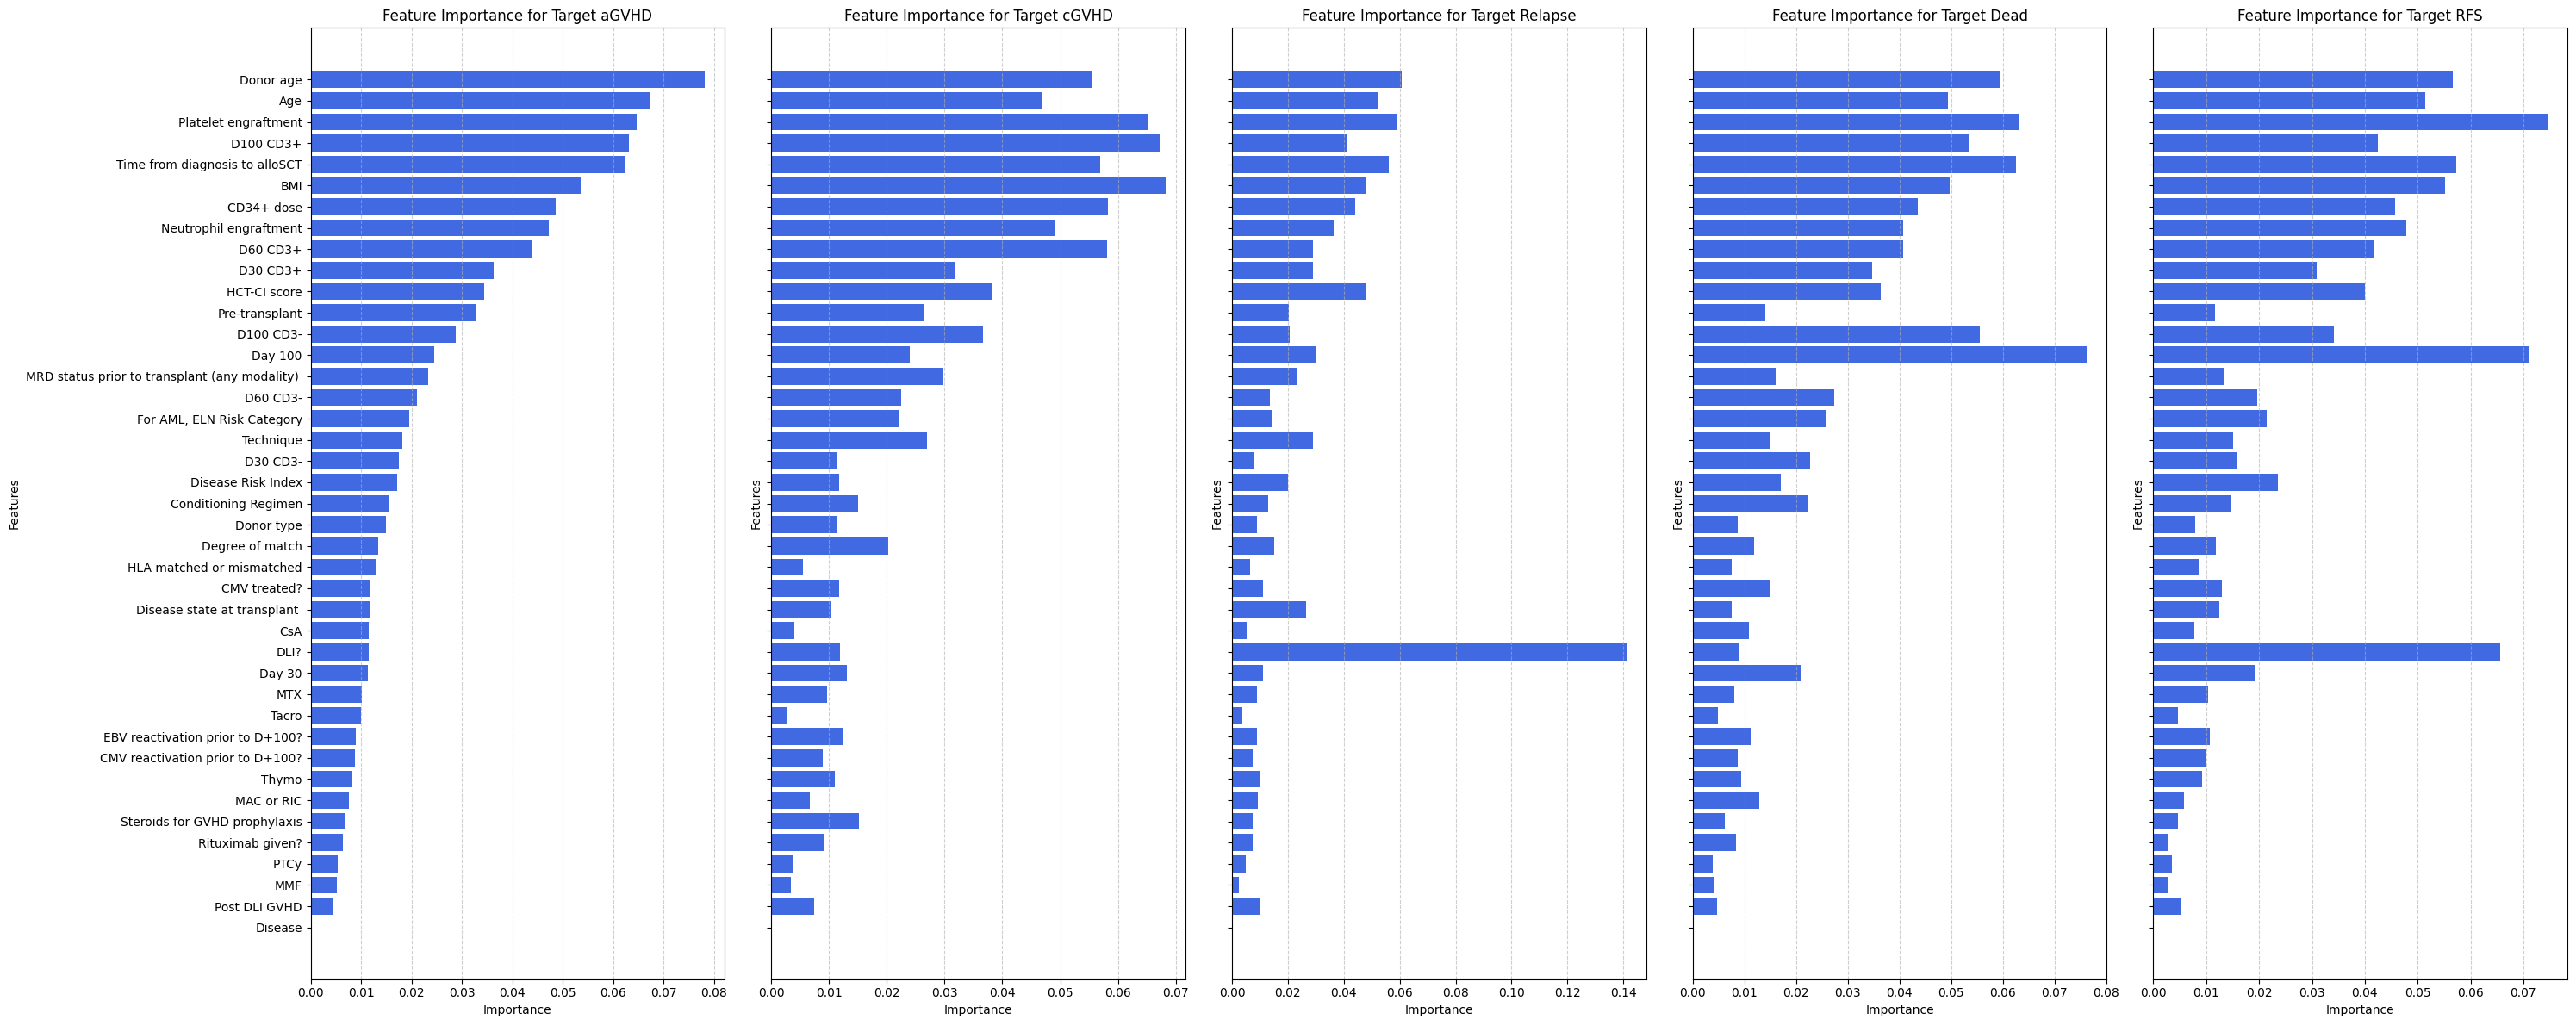

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import PCA

def plot_feature_importance_comparison(X, y_list, task="classification", method="feature_importance", n_components=10):
    """ Plot multiple feature importance comparisons in subplots """
    
    num_plots = len(y_list)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 12), sharey=True)

    if num_plots == 1:
        axes = [axes]

    for idx, (y, ax) in enumerate(zip(y_list, axes)):
        if task == "classification":
            model = RandomForestClassifier(random_state=42)
        else:
            model = RandomForestRegressor(random_state=42)

        if method == "feature_importance":
            model.fit(X, y)
            importance_scores = model.feature_importances_
            sorted_indices = np.argsort(importance_scores)[::-1]
            sorted_features = X.columns[sorted_indices]
            sorted_scores = importance_scores[sorted_indices]

        elif method == "pca":
            pca = PCA(n_components=min(n_components, X.shape[1]))
            X_pca = pca.fit_transform(X)
            sorted_indices = np.argsort(pca.components_.sum(axis=0))[::-1]
            sorted_features = X.columns[sorted_indices][:n_components]
            sorted_scores = pca.explained_variance_ratio_[:n_components]

        else:
            raise ValueError("Invalid method. Choose from 'feature_importance' or 'pca'.")

        names = ["aGVHD", "cGVHD", "Relapse", "Dead", "RFS"]

        # Plot
        ax.barh(sorted_features[::-1], sorted_scores[::-1], color='royalblue')
        ax.set_xlabel("Importance" if method == "feature_importance" else "Explained Variance Ratio")
        ax.set_ylabel("Features")
        ax.set_title(f"Feature Importance for Target {names[idx]}")
        ax.grid(axis='x', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Usage:
plot_feature_importance_comparison(X_preprocessed, [y_classification.iloc[:, i] for i in range(5)], task="classification", method="feature_importance")


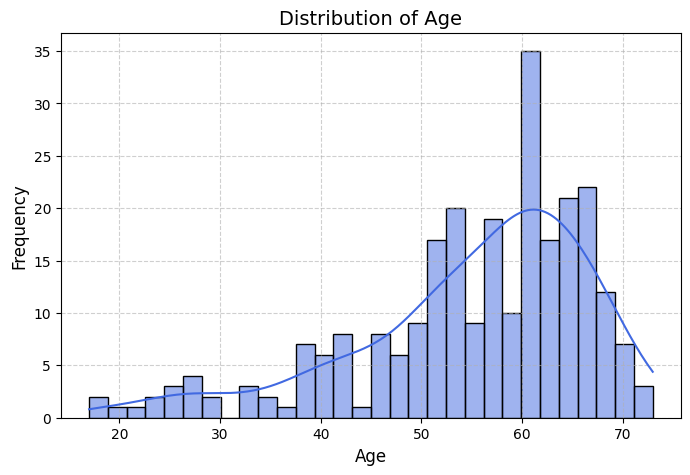

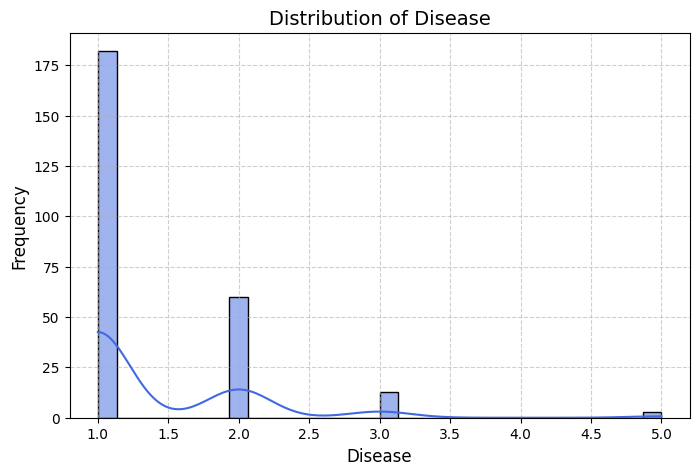

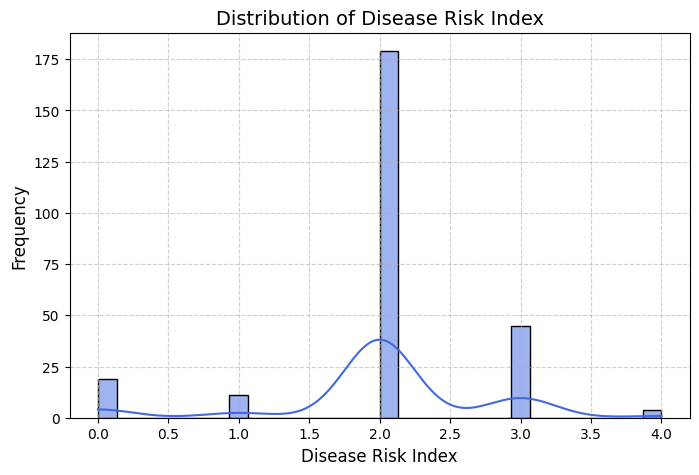

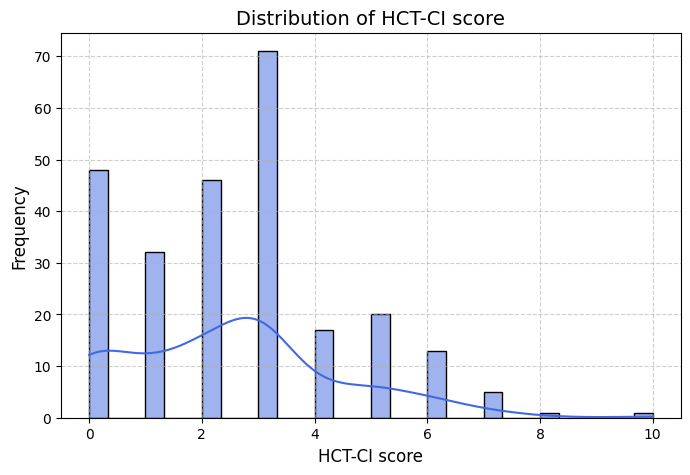

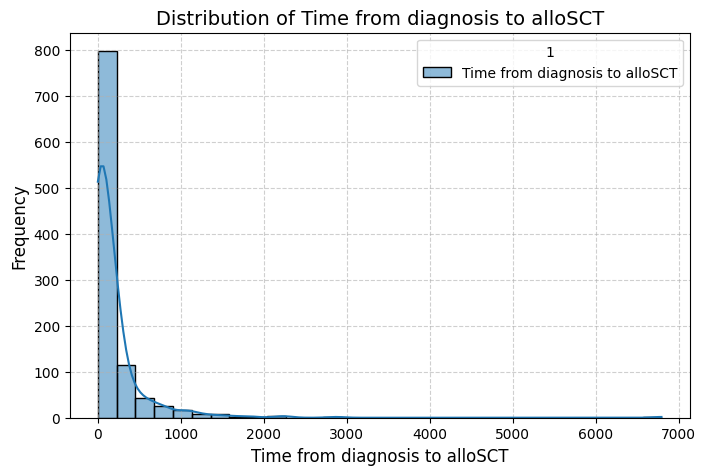

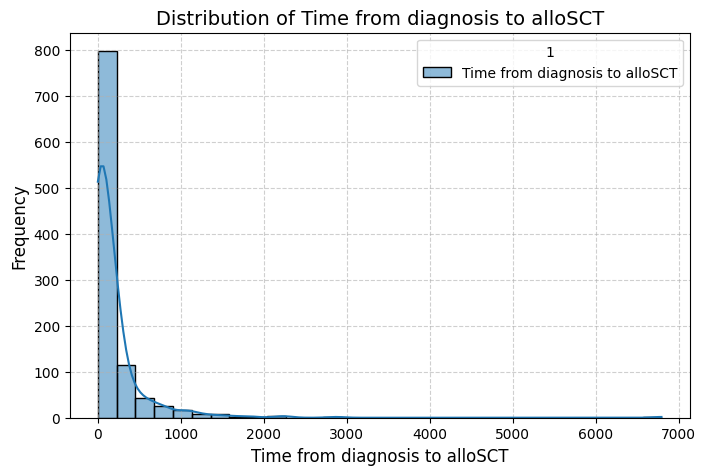

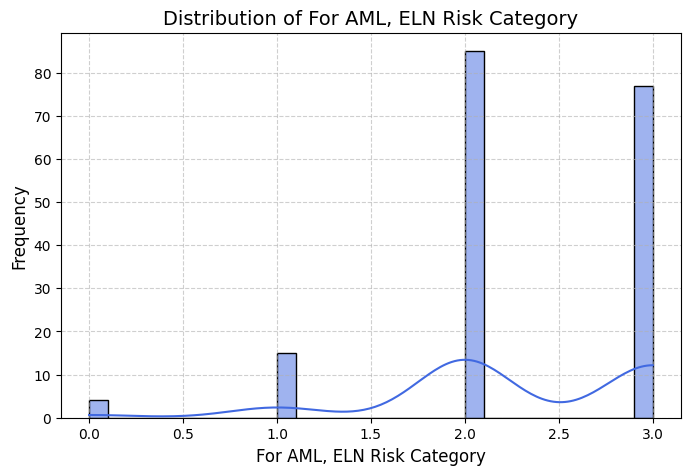

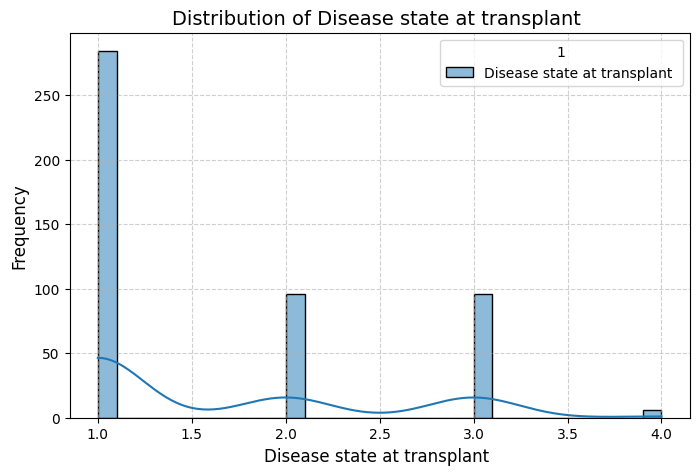

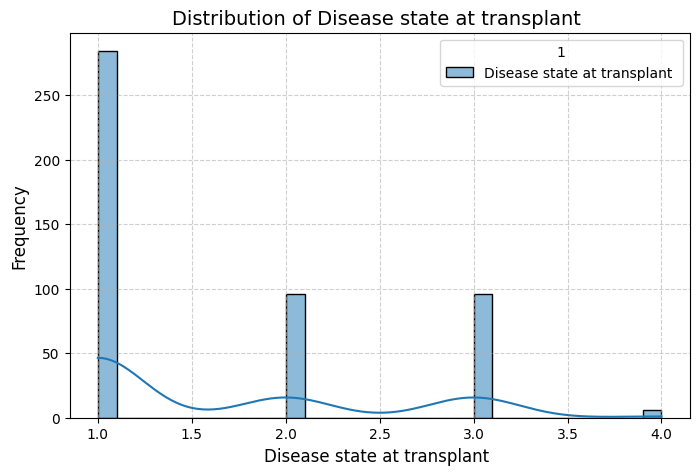

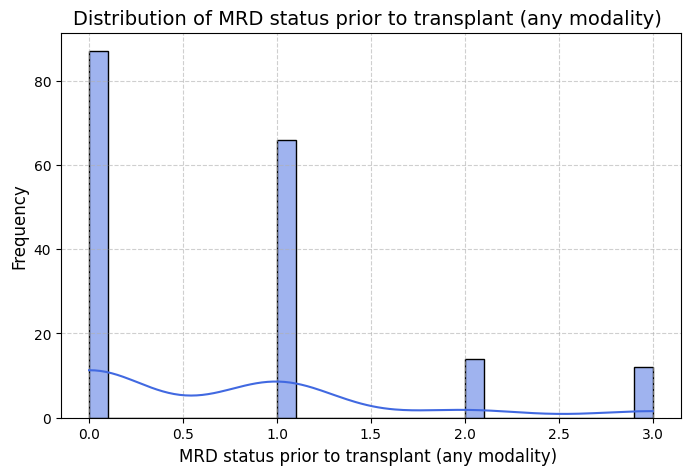

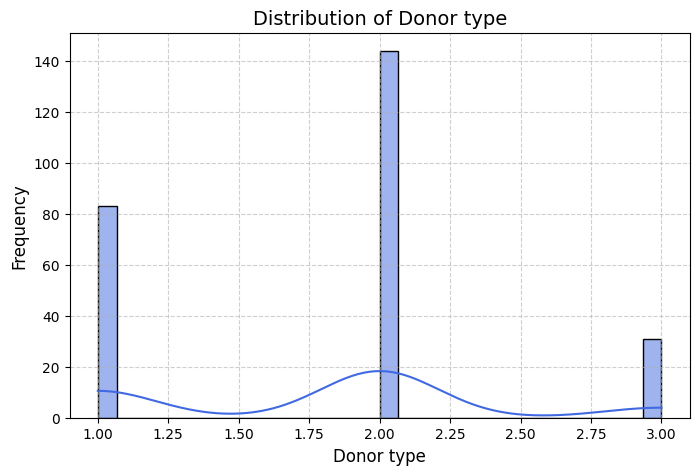

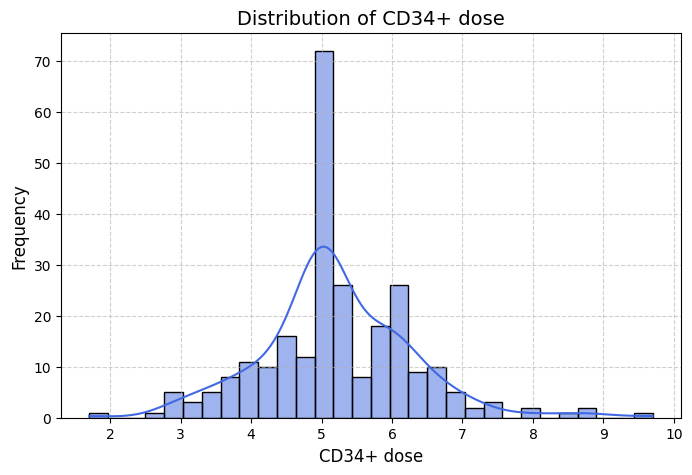

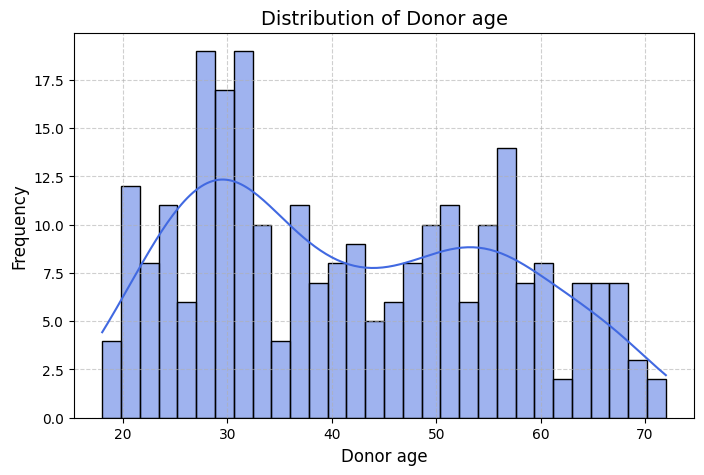

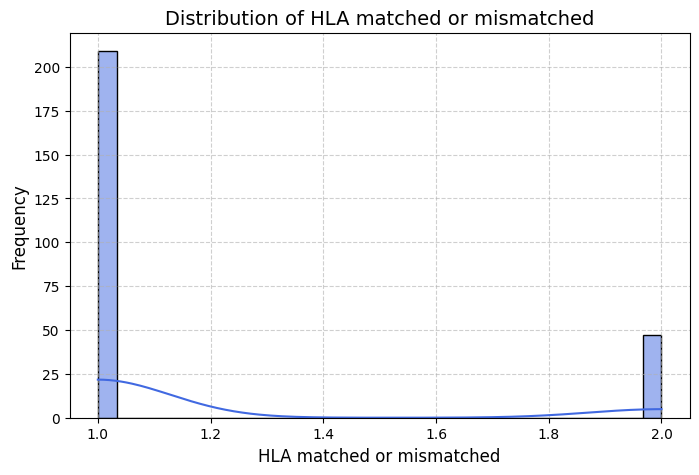

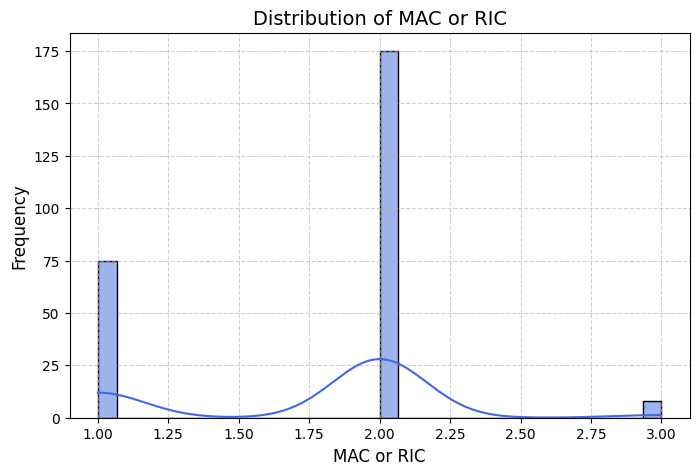

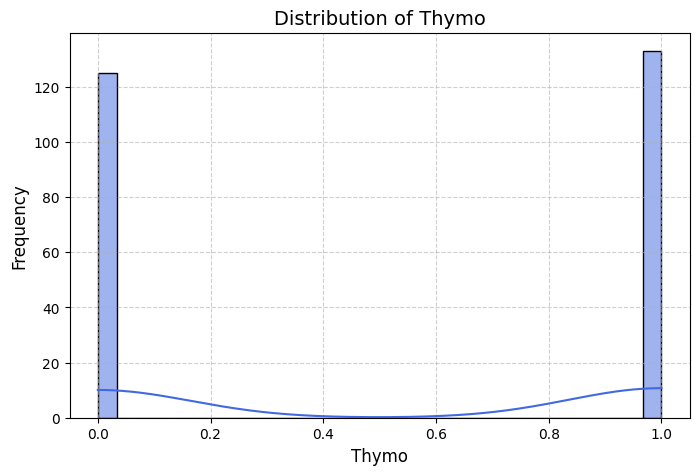

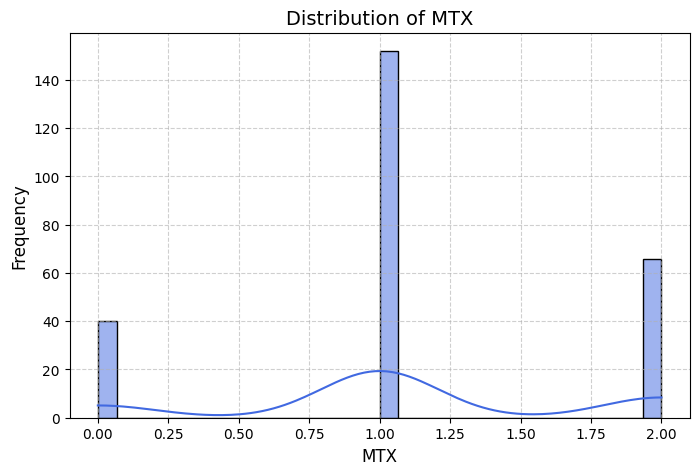

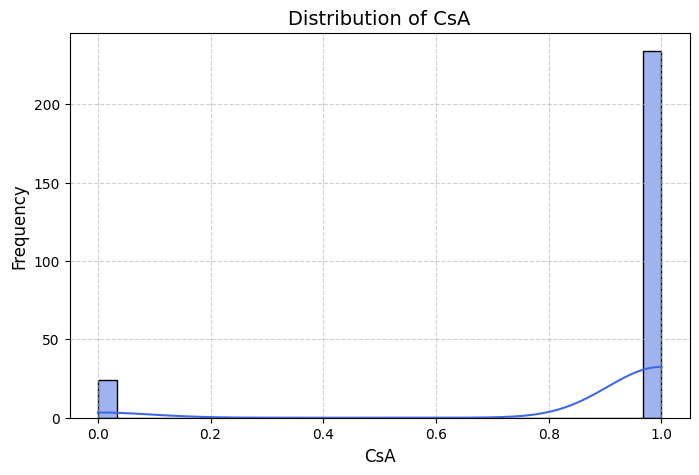

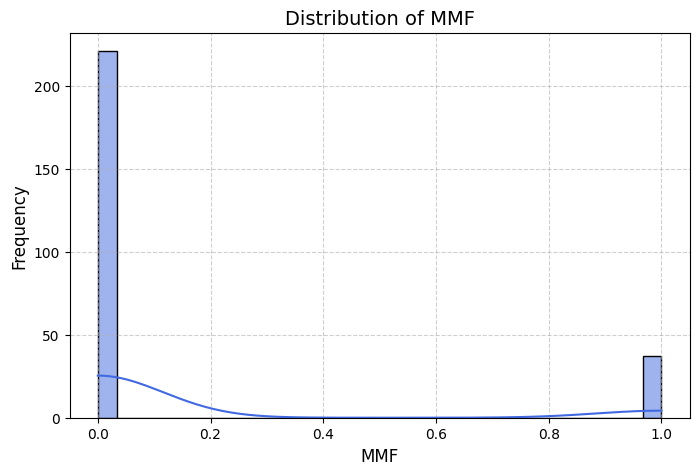

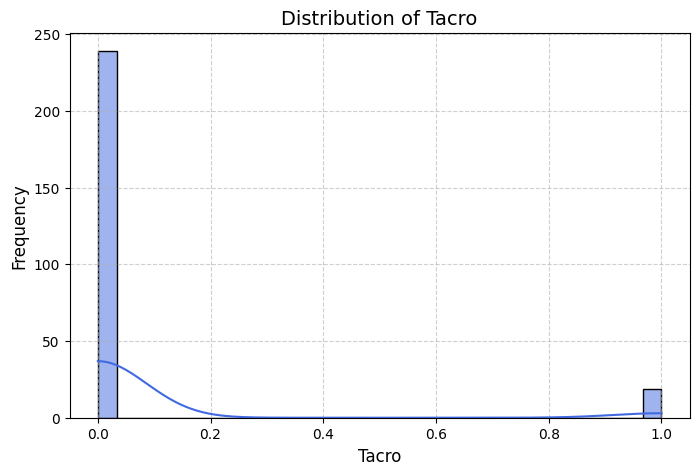

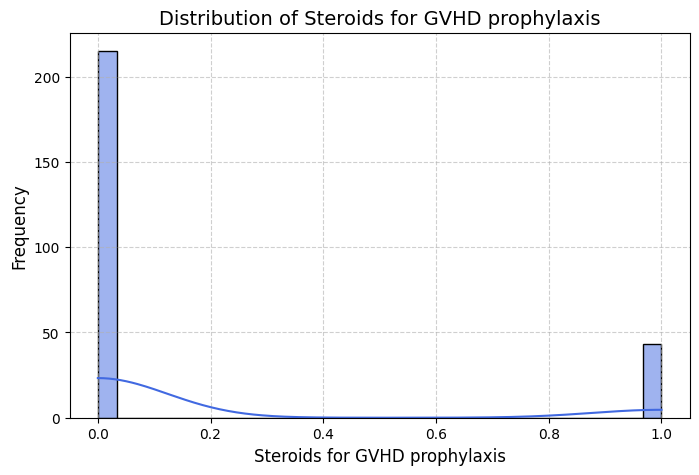

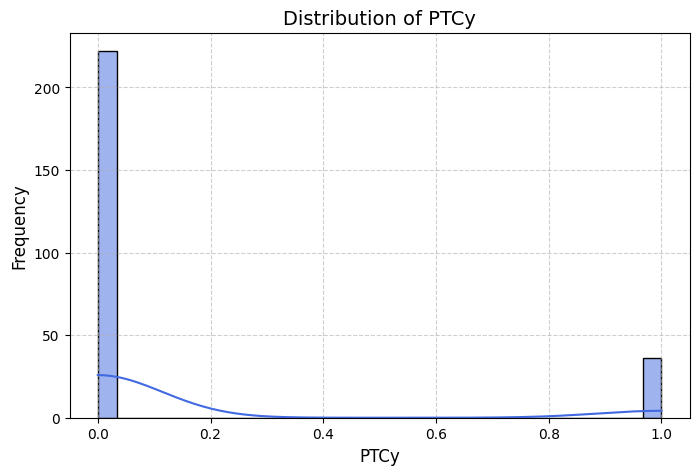

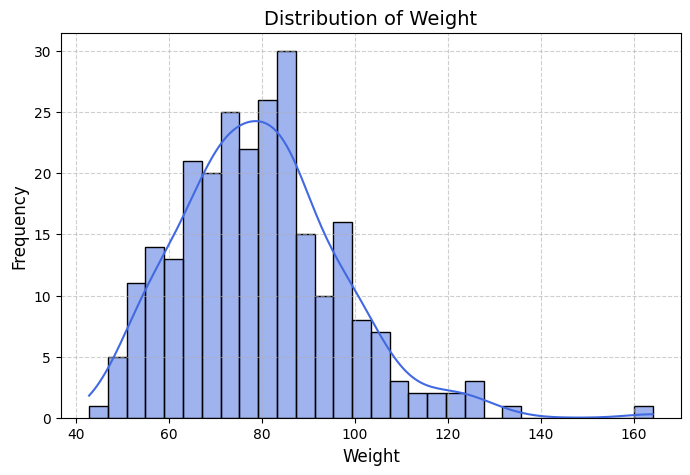

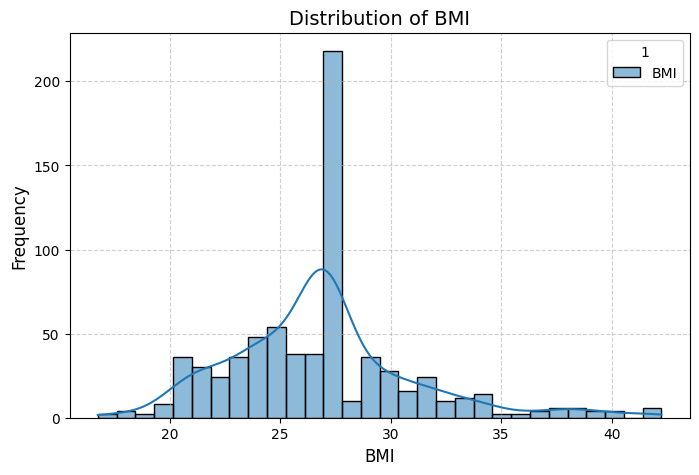

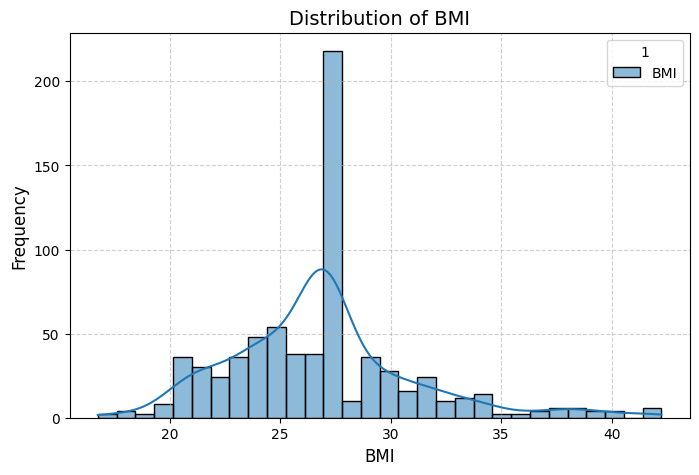

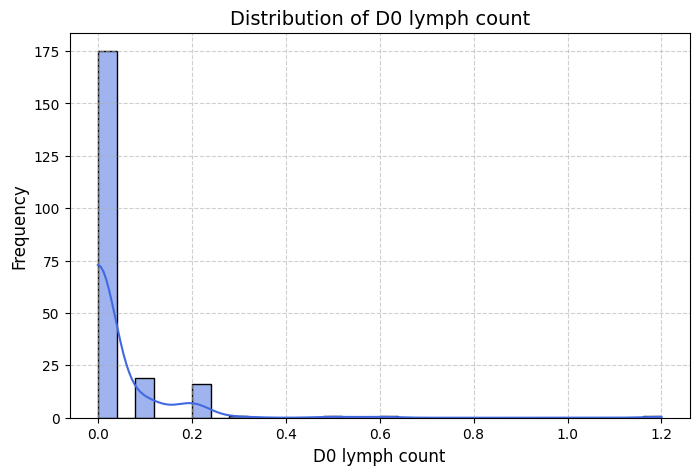

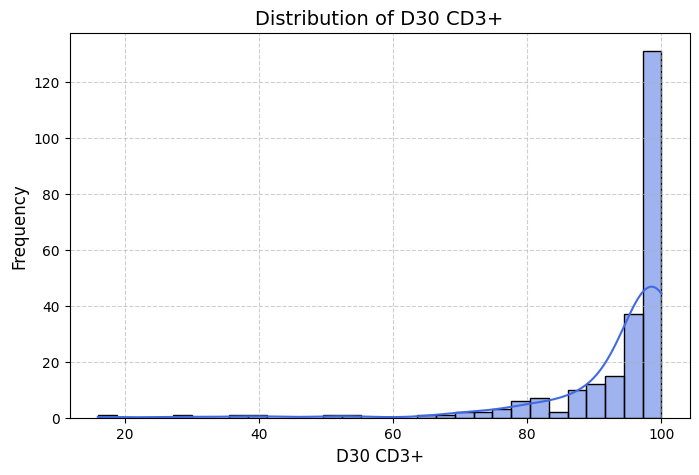

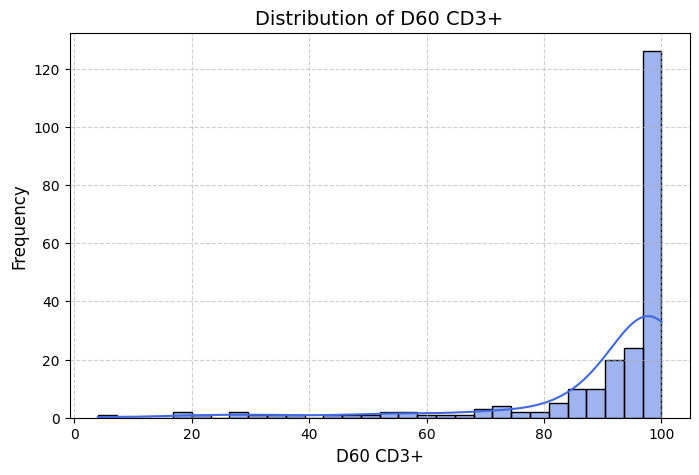

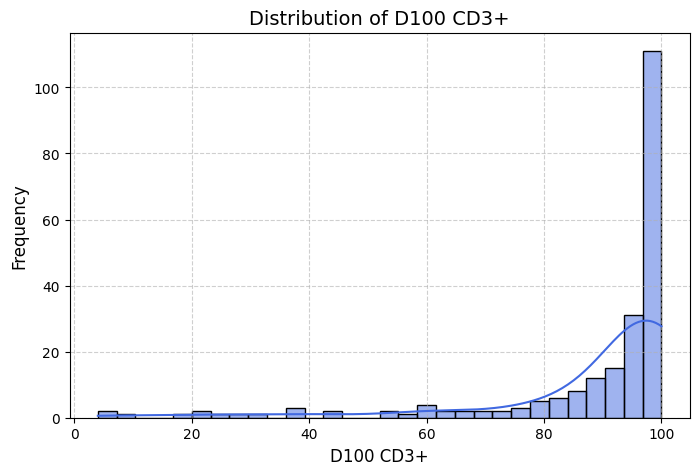

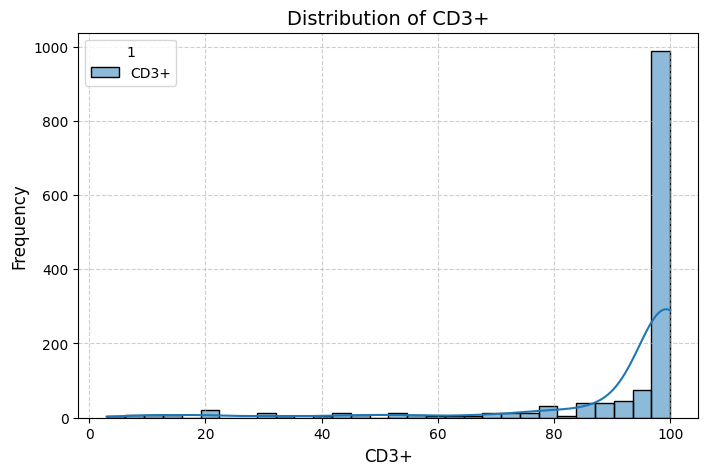

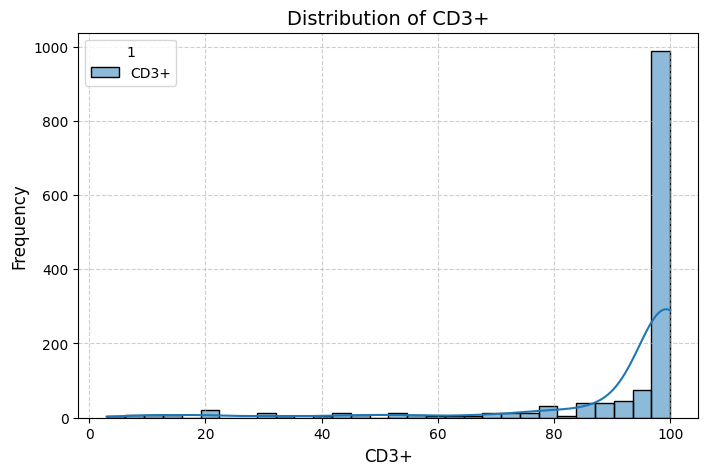

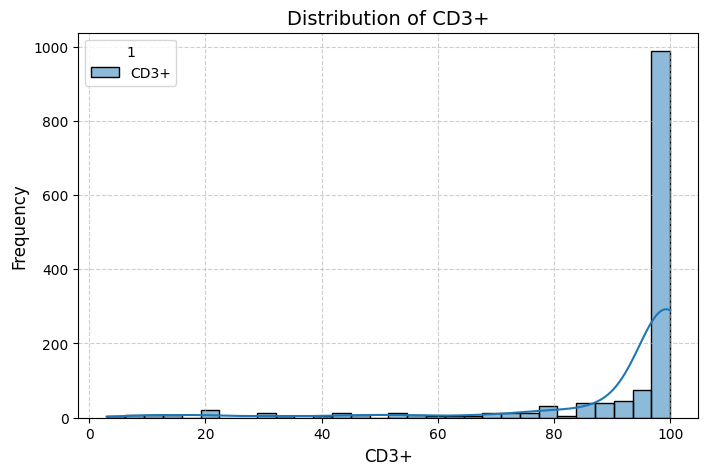

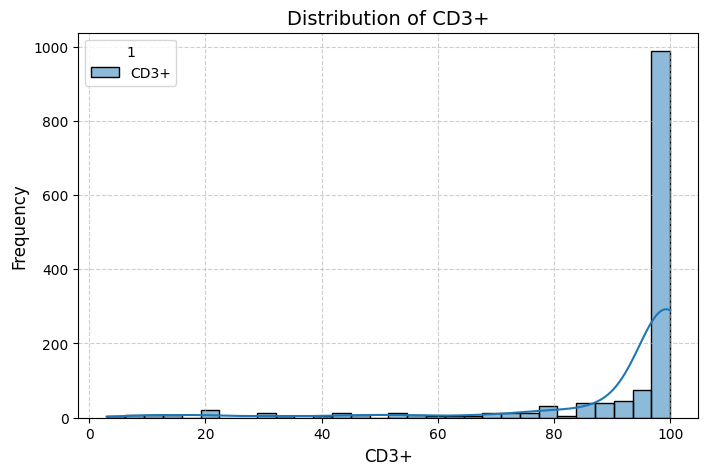

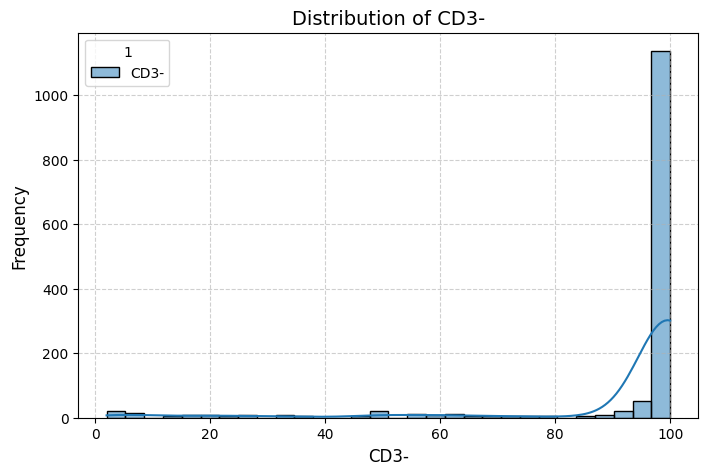

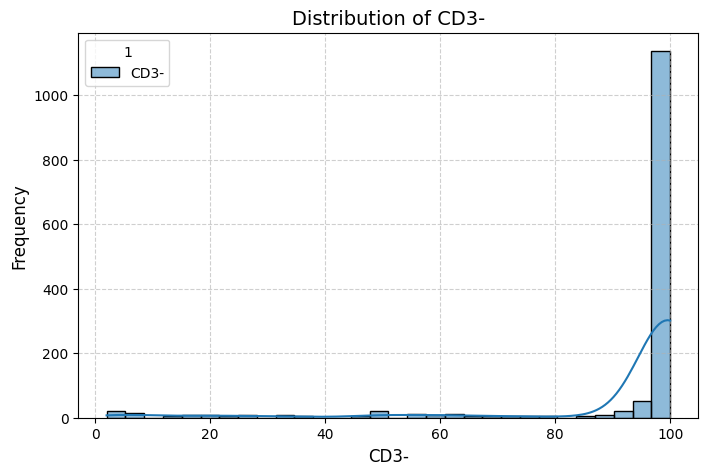

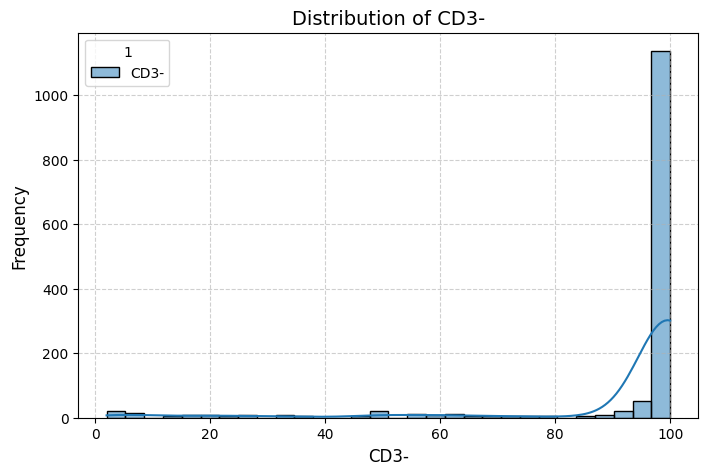

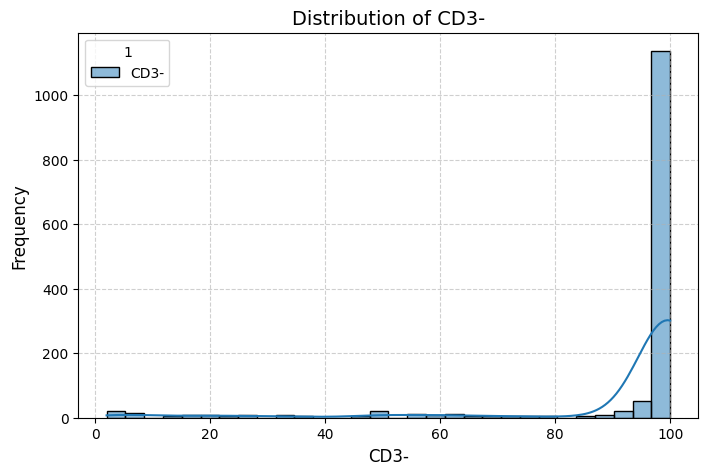

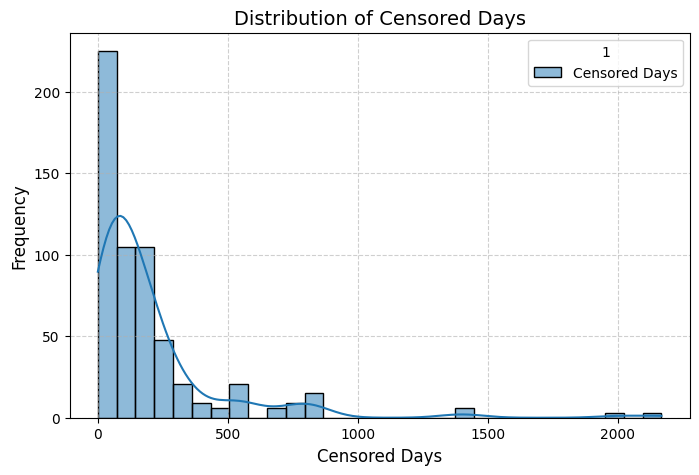

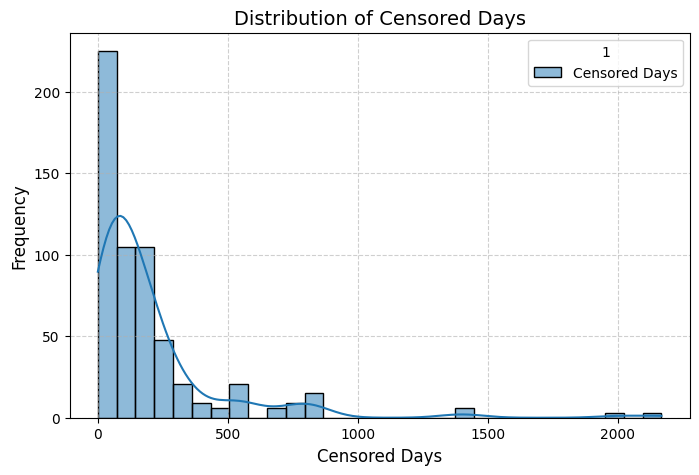

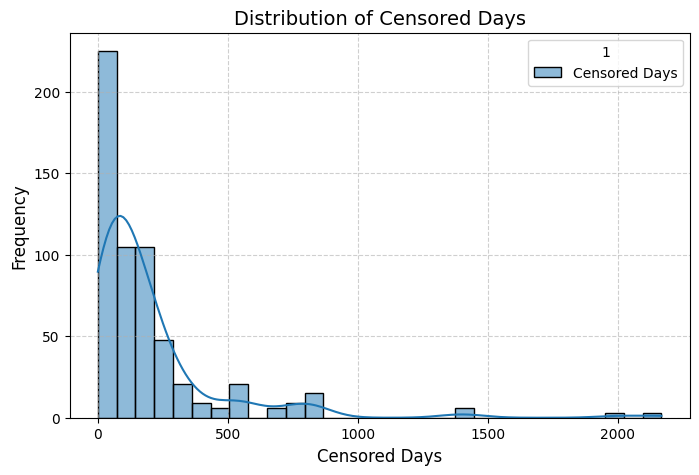

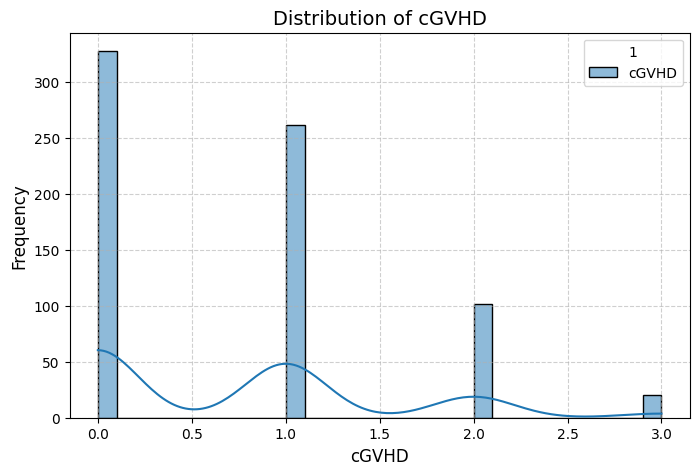

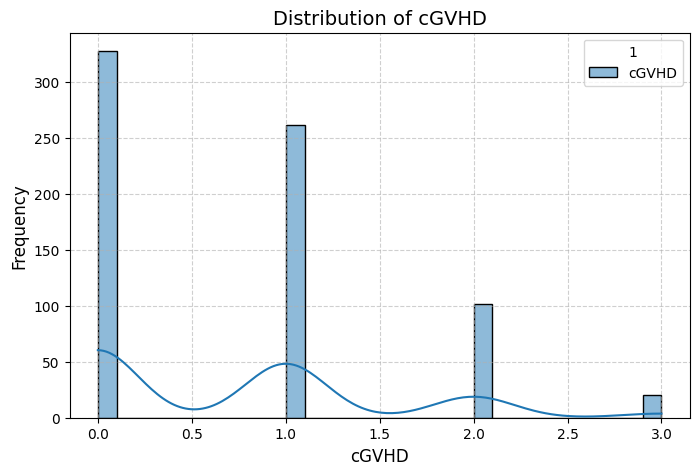

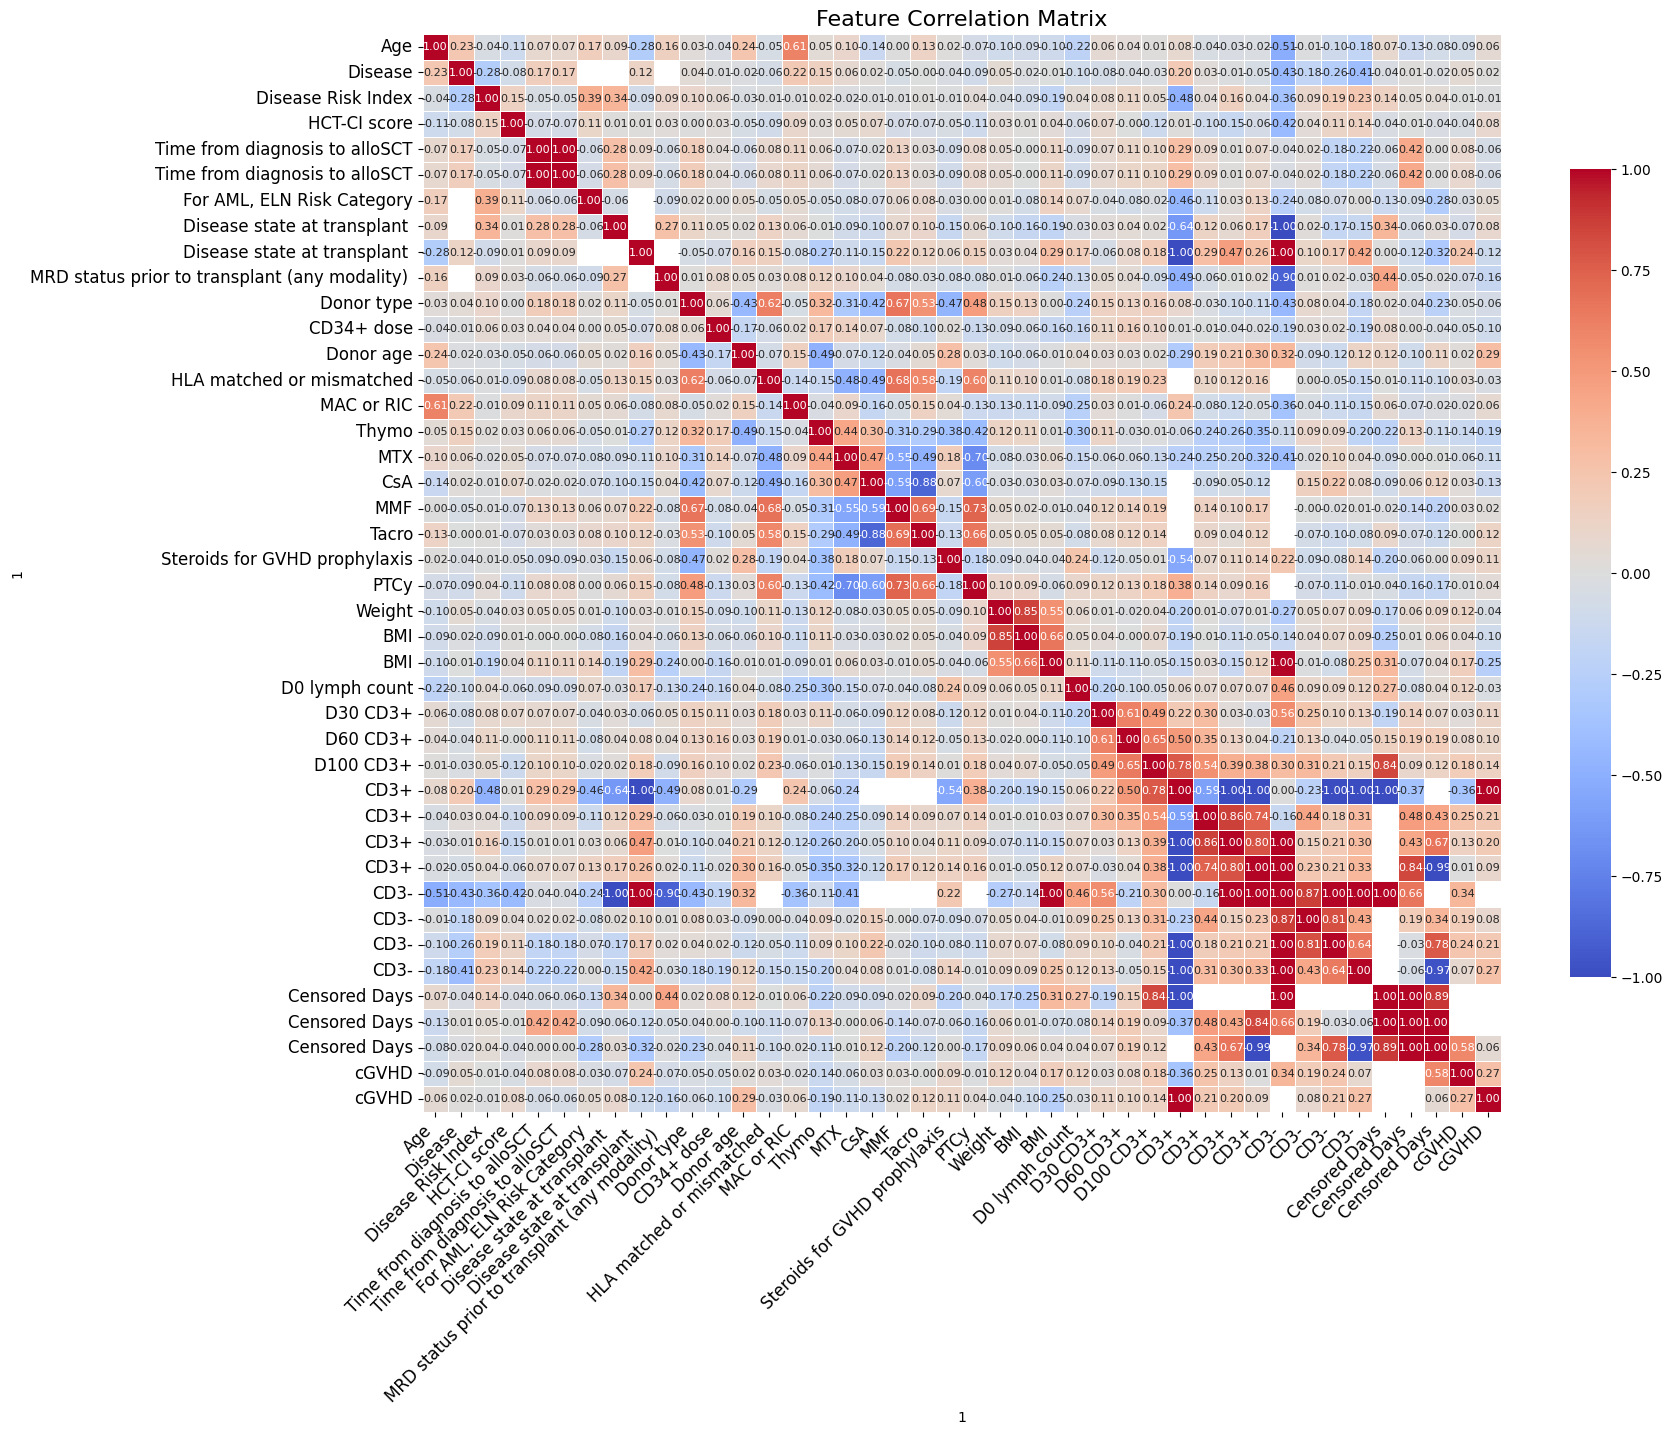

Full correlation matrix saved as correlation_matrix.csv


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_column_distributions(file_path, sheet_name, column_indices):
    # Load the Excel file
    xls = pd.ExcelFile(file_path)
    df = pd.read_excel(xls, sheet_name=sheet_name)
    
    # Rename columns based on the third row (index 1) since the first two rows seem to be headers
    df.columns = df.iloc[1]
    df = df[2:].reset_index(drop=True)
    
    # Extract the corresponding column names
    selected_columns = df.columns[column_indices]
    
    # Convert selected columns to numeric, ignoring date columns
    df_selected = df[selected_columns].apply(pd.to_numeric, errors='coerce')
    
    # Remove columns that are completely empty or have low variation
    df_selected_filtered = df_selected.dropna(axis=1, how='all')
    df_selected_filtered = df_selected_filtered.loc[:, df_selected_filtered.nunique() > 1]
    
    # Plot the distribution of the filtered columns
    for col in df_selected_filtered.columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(df_selected_filtered[col], bins=30, kde=True, color='royalblue')
        plt.title(f"Distribution of {col}", fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    
    # Plot feature correlation matrix with improved clarity
    plt.figure(figsize=(18, 14))  # Increase figure size
    correlation_matrix = df_selected_filtered.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8}, linewidths=0.6, square=True, cbar_kws={"shrink": 0.75})
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.title("Feature Correlation Matrix", fontsize=16)
    plt.show()
    
    # Save full correlation matrix to CSV file
    correlation_matrix.to_csv("correlation_matrix.csv")
    print("Full correlation matrix saved as correlation_matrix.csv")

# Example usage
file_path = "/kaggle/input/aml-mds-data/Copy of ML for AML MDS - for FG.xlsx"
sheet_name = "Sheet1"
column_indices = [4, 6, 10, 12, 14, 16, 19, 20, 62, 64, 71, 73, 74, 79, 80, 87, 88, 89, 90, 91, 92, 93, 94, 98, 104, 106,
                  108, 110, 113, 114, 116, 117, 123, 124, 133, 134, 169, 170, 171, 172]

plot_column_distributions(file_path, sheet_name, column_indices)